In [1]:
import pandas as pd
import numpy as np
import keras
import crested
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams["pdf.fonttype"] = 42  
matplotlib.rcParams["ps.fonttype"] = 42  
from pathlib import Path
import anndata
import h5py
import umap
from sklearn.manifold import TSNE

2025-03-13 16:41:13.252435: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 16:41:13.291152: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-13 16:41:16.531474: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Download the data for the notebooks from the dedicated Zenodo link of the CREsted paper. Then use it below.

In [2]:
DATA_DIR ="../../../crested_data/Figure_3/pbmc/"

# Load hg38 genome

This notebook requires an hg38 fasta file and an hg38 chromosome sizes file. You can download that here for example: https://hgdownload.soe.ucsc.edu/downloads.html 
Once downloaded, we load them to the notebook.

In [3]:
genome_dir = "../../../human/genome/"
genome_fasta = f"{genome_dir}hg38.fa"
genome_chrom_sizes  = f"{genome_dir}hg38.chrom.sizes" 

In [4]:
genome = crested.Genome(genome_fasta, genome_chrom_sizes)
crested.register_genome(genome)

2025-03-13T16:41:30.093653+0100 INFO Genome hg38 registered.


# Load DeepPBMC

In [5]:
bigwigs_folder = f"{DATA_DIR}bw/" # From De Rop et al., 2023
regions_file = f"{DATA_DIR}consensus_regions.bed"

In [6]:
adata = anndata.read_h5ad(f"{DATA_DIR}pbmc_filtered.h5ad")
adata.obs_names = pd.Index([
    'Bcell', 'CD14_monocyte', 'CD16_monocyte',
    'CD4_Tcell', 'Cytotoxic_T_cell',
    'Dendritic_cell', 'Natural_killer_cell'
])

In [7]:
model_path =f"{DATA_DIR}DeepPBMC.keras"
model = keras.models.load_model(
    model_path, compile=False
)

2025-03-13 16:41:31.208145: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78783 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:e4:00.0, compute capability: 9.0


# Region embeddings

## Get top 1,000 regions per cell type

In [9]:
predictions = crested.tl.predict(adata, model)
adata.layers["deeppbmc"] = predictions.T  # adata expects (C, N) instead of (N, C)

I0000 00:00:1741880527.836706 3382290 service.cc:145] XLA service 0x7f0cec003800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741880527.836735 3382290 service.cc:153]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
2025-03-13 16:42:07.852672: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-13 16:42:07.949296: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  223/62017 ━━━━━━━━━━━━━━━━━━━━ 42s 680us/step

I0000 00:00:1741880528.661387 3382290 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62017/62017 ━━━━━━━━━━━━━━━━━━━━ 42s 668us/step


In [10]:
adata_combined = adata.copy()  # Copy the peak heights
adata_combined.X = (
    adata_combined.X + adata_combined.layers["deeppbmc"]
) / 2  # Take the average with the predictions

In [11]:
adata_filtered = adata_combined.copy()
top_k = 1000
crested.pp.sort_and_filter_regions_on_specificity(
    adata_filtered, top_k=top_k, method="proportion"
)
adata_filtered.var

2025-03-13T16:43:06.738801+0100 INFO After sorting and filtering, kept 7000 regions.


,chr,start,end,split,Class name,rank,proportion_score
region,,,,,,,
chrY:7452461-7454575,chrY,7452461,7454575,train,Bcell,1,0.982844
chr7:846223-848337,chr7,846223,848337,train,Bcell,2,0.972710
chrX:104696353-104698467,chrX,104696353,104698467,train,Bcell,3,0.971274
chr3:16432755-16434869,chr3,16432755,16434869,train,Bcell,4,0.966042
chr15:69978952-69981066,chr15,69978952,69981066,train,Bcell,5,0.963845
...,...,...,...,...,...,...,...
chr8:89804345-89806459,chr8,89804345,89806459,val,Natural_killer_cell,996,0.682785
chr2:112167616-112169730,chr2,112167616,112169730,train,Natural_killer_cell,997,0.682778
chrX:50385679-50387793,chrX,50385679,50387793,train,Natural_killer_cell,998,0.682692


## Get region embeddings, reduce dimensionality and plot

In [12]:
adata_clust = adata_filtered # use 'adata' if you want to cluster all regions from the adata object

predictions = crested.tl.predict(adata_clust, model)
adata_clust.layers["deeppbmc"] = predictions.T  # adata expects (C, N) instead of (N, C)

emb = crested.tl.extract_layer_embeddings(adata_clust, model, layer_name='global_average_pooling1d')
emb.shape

7000/7000 ━━━━━━━━━━━━━━━━━━━━ 5s 666us/step
7000/7000 ━━━━━━━━━━━━━━━━━━━━ 5s 658us/step


(7000, 512)

In [13]:
# Select dimensionality reduction method: 'umap' or 'tsne'
method = "tsne"  # Change to "tsne" if needed

from sklearn.decomposition import PCA

# Load data
column_names = list(adata_clust.obs_names)
data = crested.pp._utils._calc_proportion(emb)

idcs= np.random.choice(data.shape[0], len(adata_clust.X.T), replace=False)
data= data[idcs]

pca = PCA(n_components=50, random_state=42)  # Reduce to 50D before UMAP/t-SNE
reduced_data = pca.fit_transform(data) 

# Dimensionality reduction
if method == "umap":
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(reduced_data)
elif method == "tsne":
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    embedding = reducer.fit_transform(reduced_data)
else:
    raise ValueError("Invalid method. Choose 'umap' or 'tsne'.")

### Fig. 3a

/data/tmp/60289/ipykernel_3382179/1813631796.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(column_names))


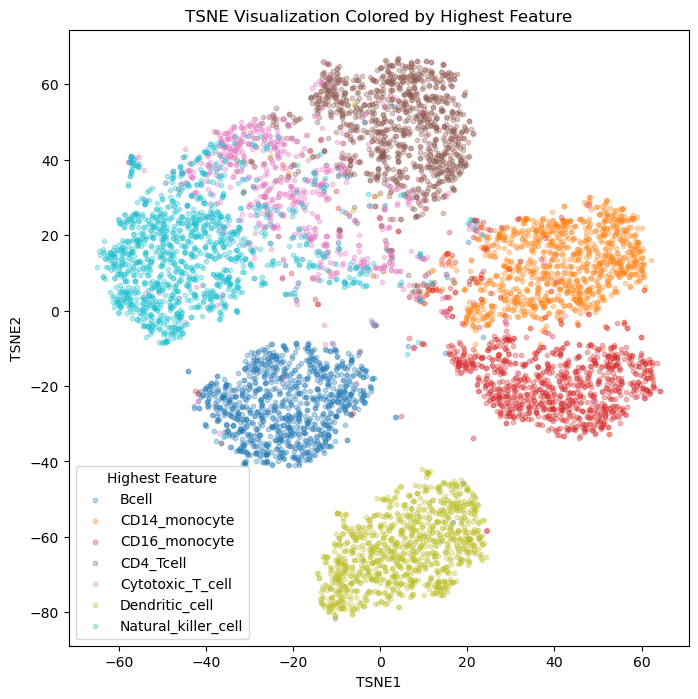

In [14]:
color_by = 'combined_peak_prediction' # choice between label, max_peak, max_prediction, combined_peak_prediction

max_column_names=None
if color_by=='label':
    max_column_names = adata_clust.var['Class name'].values[idcs]
elif color_by=='combined_peak_prediction':
    vals = (adata_clust.X.T[idcs] + adata_clust.layers['deeppbmc'].T[idcs])/2
elif color_by=='max_peak':
    vals = adata_clust.layers['deeppbmc'].T[idcs]
elif color_by=='max_prediction':
    vals = adata_clust.X.T[idcs]

if max_column_names is None:
    # Find the highest contributing feature per row
    max_column_indices = np.argmax(vals, axis=1)  # Index of the column with the highest value per row
    max_column_names = [column_names[idx] for idx in max_column_indices]  # Get column names for each row


# Convert embedding to a DataFrame for visualization
embedding_df = pd.DataFrame(embedding, columns=[f"{method.upper()}1", f"{method.upper()}2"])
embedding_df["Highest Feature"] = max_column_names  # Add the highest column name for coloring
colormap = plt.cm.get_cmap('tab10', len(column_names))

plt.figure(figsize=(8, 8))
for i, feature in enumerate(column_names):
    subset = embedding_df[embedding_df["Highest Feature"] == feature]
    plt.scatter(subset[f"{method.upper()}1"], subset[f"{method.upper()}2"], label=feature, alpha=0.3, rasterized=True, s=10,color=colormap(i))#s = 1.5)

plt.title(f"{method.upper()} Visualization Colored by Highest Feature")
plt.xlabel(f"{method.upper()}1")
plt.ylabel(f"{method.upper()}2")
plt.legend(title="Highest Feature")
plt.savefig('pbmc_reg_tsne_'+color_by+'.pdf', bbox_inches='tight')
plt.show()

### Cluster all (filtered) peaks
Fig. S5
Optional, computationally expensive

In [15]:
adata_clust = adata # use 'adata' if you want to cluster all regions from the adata object

predictions = crested.tl.predict(adata_clust, model)
adata_clust.layers["deeppbmc"] = predictions.T  # adata expects (C, N) instead of (N, C)

emb = crested.tl.extract_layer_embeddings(adata_clust, model, layer_name='global_average_pooling1d')
emb.shape

62017/62017 ━━━━━━━━━━━━━━━━━━━━ 42s 673us/step
62017/62017 ━━━━━━━━━━━━━━━━━━━━ 41s 661us/step


(62017, 512)

In [16]:
# Select dimensionality reduction method: 'umap' or 'tsne'
method = "tsne"  # Change to "tsne" if needed

from sklearn.decomposition import PCA

# Load data
column_names = list(adata_clust.obs_names)
data = crested.pp._utils._calc_proportion(emb)

idcs= np.random.choice(data.shape[0], len(adata_clust.X.T), replace=False)
data= data[idcs]

pca = PCA(n_components=50, random_state=42)  # Reduce to 50D before UMAP/t-SNE
reduced_data = pca.fit_transform(data) 

# Dimensionality reduction
if method == "umap":
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(reduced_data)
elif method == "tsne":
    reducer = TSNE(n_components=2, random_state=42, perplexity=30)
    embedding = reducer.fit_transform(reduced_data)
else:
    raise ValueError("Invalid method. Choose 'umap' or 'tsne'.")

/data/tmp/60289/ipykernel_3382179/3406363908.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(column_names))


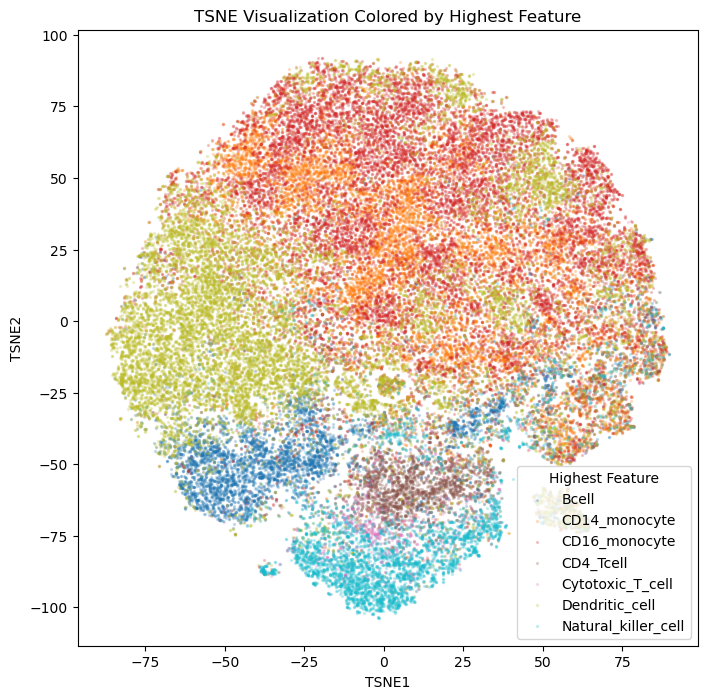

In [17]:
color_by = 'combined_peak_prediction' # Choice between max_peak, max_prediction, combined_peak_prediction

max_column_names=None
if color_by=='combined_peak_prediction':
    vals = (adata_clust.X.T[idcs] + adata_clust.layers['deeppbmc'].T[idcs])/2
elif color_by=='max_peak':
    vals = adata_clust.layers['deeppbmc'].T[idcs]
elif color_by=='max_prediction':
    vals = adata_clust.X.T[idcs]

max_column_indices = np.argmax(vals, axis=1)  # Index of the column with the highest value per row
max_column_names = [column_names[idx] for idx in max_column_indices]  # Get column names for each row


# Convert embedding to a DataFrame for visualization
embedding_df = pd.DataFrame(embedding, columns=[f"{method.upper()}1", f"{method.upper()}2"])
embedding_df["Highest Feature"] = max_column_names  # Add the highest column name for coloring
colormap = plt.cm.get_cmap('tab10', len(column_names))

plt.figure(figsize=(8, 8))
for i, feature in enumerate(column_names):
    subset = embedding_df[embedding_df["Highest Feature"] == feature]
    plt.scatter(subset[f"{method.upper()}1"], subset[f"{method.upper()}2"], label=feature, alpha=0.2, rasterized=True, s=2,color=colormap(i))#s = 1.5)

plt.title(f"{method.upper()} Visualization Colored by Highest Feature")
plt.xlabel(f"{method.upper()}1")
plt.ylabel(f"{method.upper()}2")
plt.legend(title="Highest Feature")
#plt.savefig('paperfigs/pbmc_reg_tsne_ALL_'+color_by+'.pdf', bbox_inches='tight')
plt.show()

/data/tmp/60289/ipykernel_3382179/412676613.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('tab10', len(column_names))


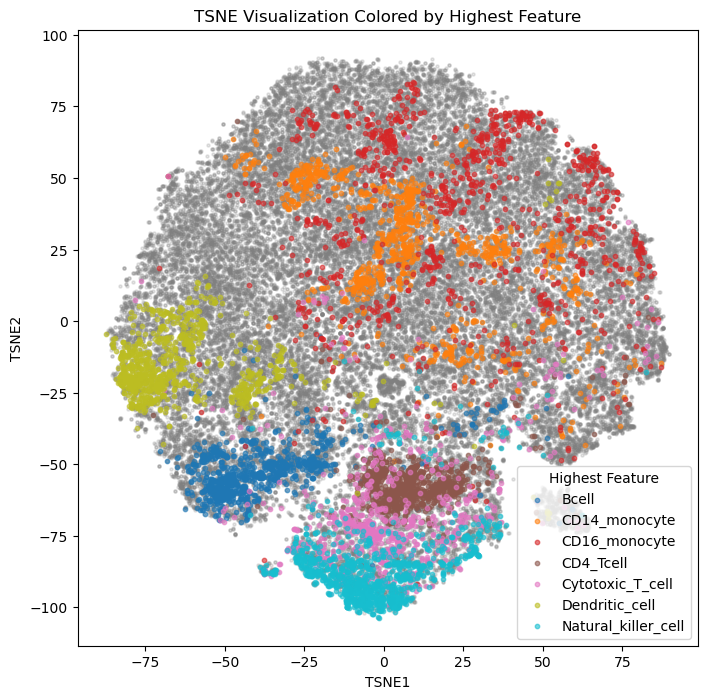

In [18]:
# Identify regions to color
regions_to_color = adata_filtered.var.index

color_by = 'combined_peak_prediction' # Choice between max_peak, max_prediction, combined_peak_prediction

max_column_names=None
if color_by=='label':
    max_column_names = adata_clust.var['Class name'].values[idcs]
elif color_by=='combined_peak_prediction':
    vals = (adata_clust.X.T[idcs] + adata_clust.layers['deeppbmc'].T[idcs])/2
elif color_by=='max_peak':
    vals = adata_clust.layers['deeppbmc'].T[idcs]
elif color_by=='max_prediction':
    vals = adata_clust.X.T[idcs]

max_column_indices = np.argmax(vals, axis=1)  # Index of the column with the highest value per row
max_column_names = [column_names[idx] for idx in max_column_indices]  # Get column names for each row

# Convert embedding to a DataFrame for visualization
embedding_df = pd.DataFrame(embedding, columns=[f"{method.upper()}1", f"{method.upper()}2"])
embedding_df["Highest Feature"] = max_column_names

# Define colormap for regions of interest
colormap = plt.cm.get_cmap('tab10', len(column_names))

plt.figure(figsize=(8, 8))

# Plot other regions in gray
gray_subset = embedding_df[~adata.var.iloc[idcs].index.isin(regions_to_color)]
plt.scatter(gray_subset[f"{method.upper()}1"], gray_subset[f"{method.upper()}2"], color='gray', alpha=0.2, rasterized=True, s=5)

# Plot regions of interest with their highest feature color
for i, feature in enumerate(column_names):
    subset = embedding_df[(embedding_df["Highest Feature"] == feature) & (adata.var.iloc[idcs].index.isin(regions_to_color))]
    plt.scatter(subset[f"{method.upper()}1"], subset[f"{method.upper()}2"], label=feature, alpha=0.6, rasterized=True, s=10, color=colormap(i))


plt.title(f"{method.upper()} Visualization Colored by Highest Feature")
plt.xlabel(f"{method.upper()}1")
plt.ylabel(f"{method.upper()}2")
plt.legend(title="Highest Feature")
#plt.savefig('pbmc_reg_tsne_'+color_by+'_ALL_filtered.pdf', bbox_inches='tight')
plt.show()


# Enhancer examples

## CD79a enhancer


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


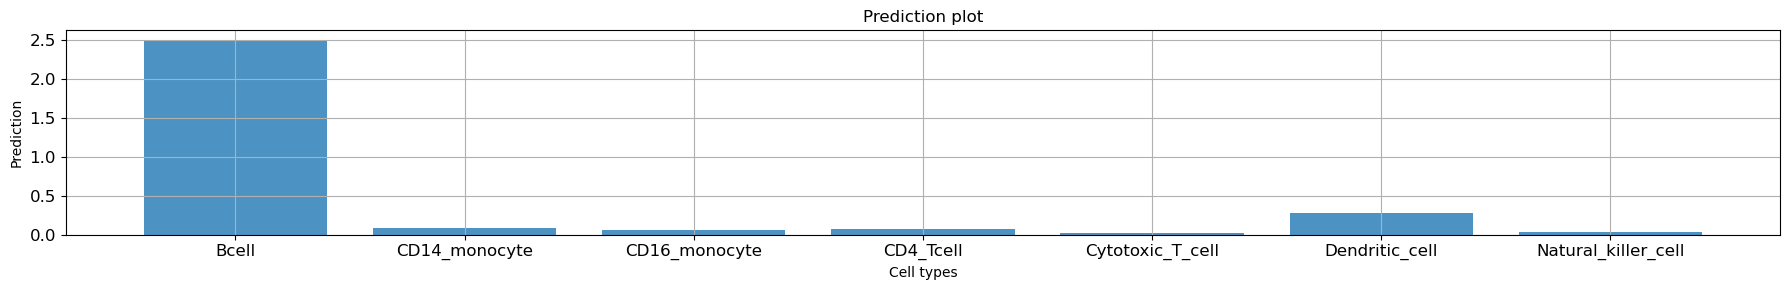

In [19]:
from pysam import FastaFile

chrom='chr19'
start=41876086-30
end=start+2114

length=end-start
padding = int((2114-length)//2)
start=start-padding
end=end+padding

sequence = genome.fetch(chrom, start, end).upper()

prediction = crested.tl.predict(sequence, model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))

In [20]:
classes_of_interest = ['Bcell']
sequence = genome.fetch(chrom, start, end).upper()

class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model,
)
scores_ism, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model,
    method='mutagenesis'
) 

2025-03-13T16:53:02.303466+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]

2025-03-13T16:53:05.523406+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:05<00:00,  5.97s/it]


### Fig 3b (top)

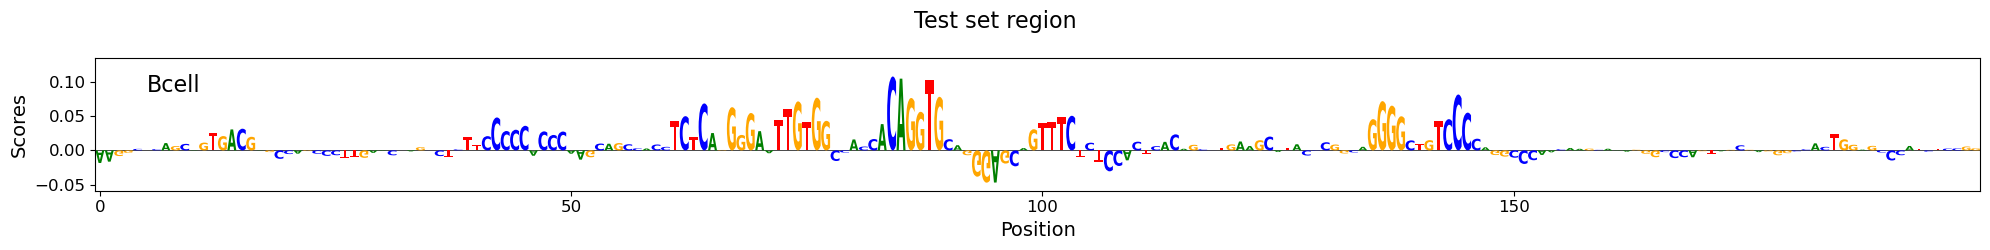

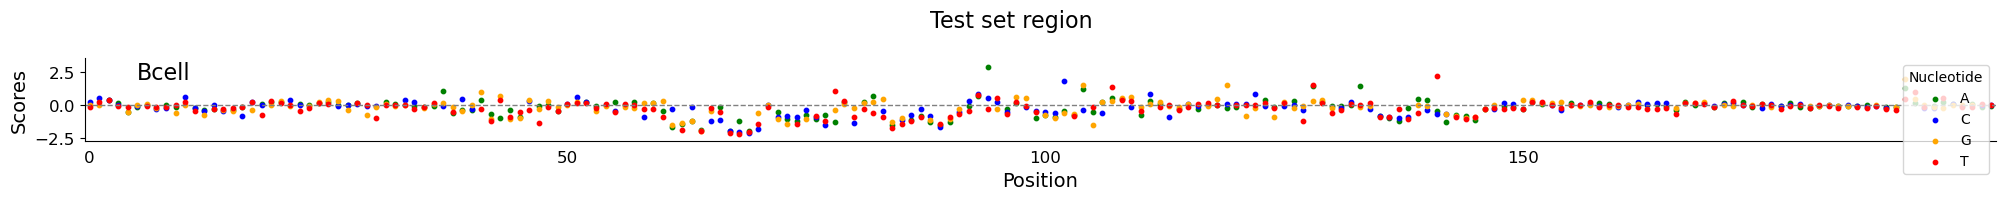

In [21]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=200,
    title="Test set region",
    height=2.5,
    #save_path = 'paperfigs/cd79a.pdf',
) 

crested.pl.patterns.contribution_scores(
    scores_ism,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=200,
    title="Test set region",
    height=2,
    method='mutagenesis'
)

## TCR-alpha Ea core

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


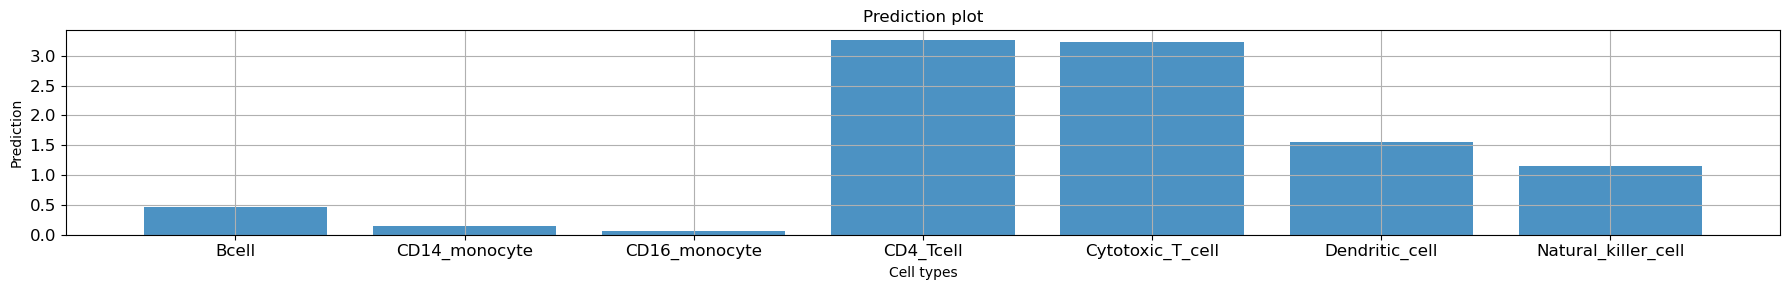

In [22]:
chrom='chr14'
start=22555423-20
end=start+2114

length=end-start
padding = int((2114-length)//2)
start=start-padding
end=end+padding

sequence = genome.fetch(chrom, start, end).upper()

prediction = crested.tl.predict(sequence, model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))

In [23]:
classes_of_interest = ['CD4_Tcell']
sequence = genome.fetch(chrom, start, end).upper()

class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model,
)
scores_ism, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model,
    method='mutagenesis'
) 

2025-03-13T16:53:12.697529+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:01<00:00,  1.26s/it]

2025-03-13T16:53:13.955817+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).



Model: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


### Fig. 3b (bottom)

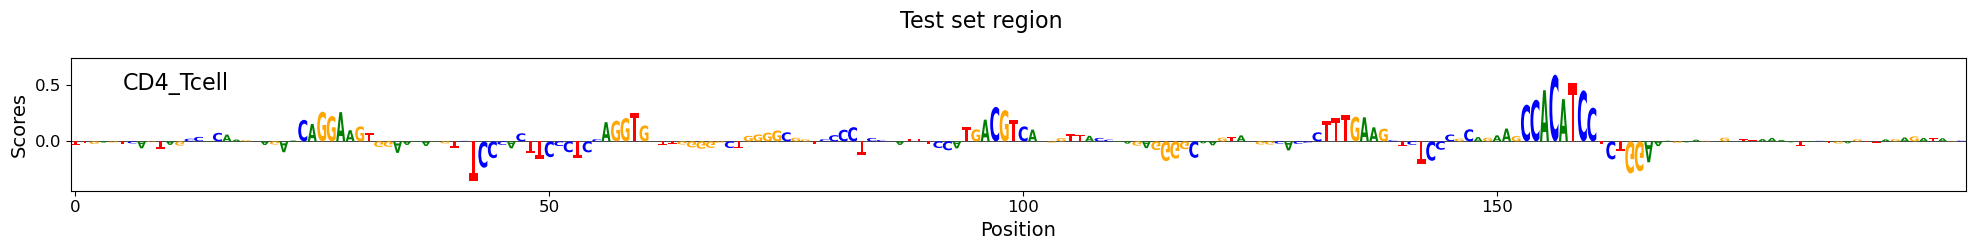

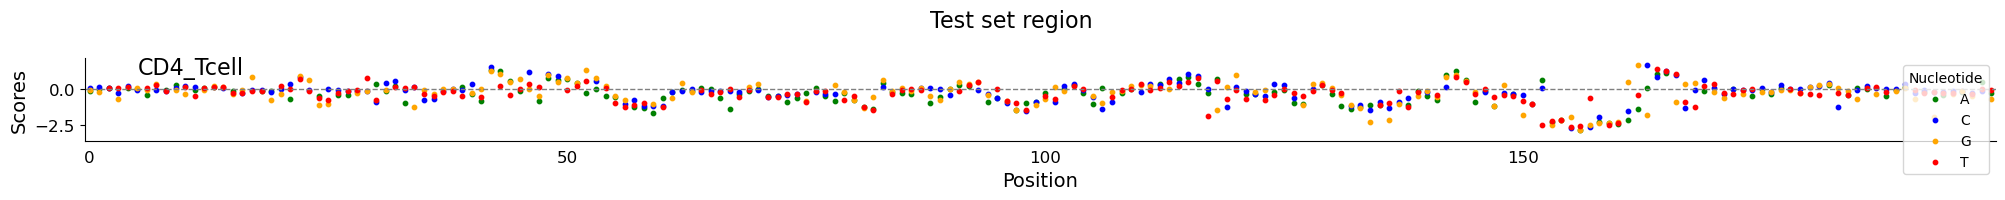

In [24]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=200,
    title="Test set region",
    height=2.5,
    #save_path = 'paperfigs/tcr_ea_core.pdf',
) 

crested.pl.patterns.contribution_scores(
    scores_ism,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=200,
    title="Test set region",
    height=2,
    method='mutagenesis'
)

## IFN-b enhanceosome

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


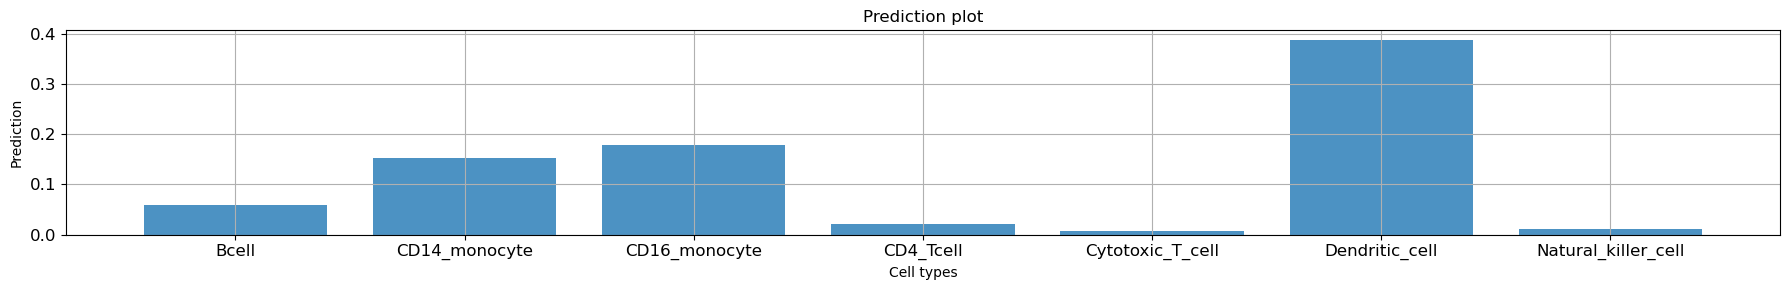

In [25]:
chrom='chr9'
start=21076963
end=21079077

length=end-start
padding = int((2114-length)//2)
start=start-padding
end=end+padding

sequence = genome.fetch(chrom, start, end).upper()

complement = str.maketrans("ATCGatcg", "TAGCtagc")
seq_rev = sequence.translate(complement)[::-1]

prediction = crested.tl.predict(sequence, model)
crested.pl.bar.prediction(prediction, classes=list(adata.obs_names))

In [26]:
classes_of_interest = ['Dendritic_cell']
sequence = genome.fetch(chrom, start, end).upper()

class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence,
    target_idx=class_idx,
    model=model,
)

2025-03-13T16:53:17.595095+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


### Fig. 3c (top)

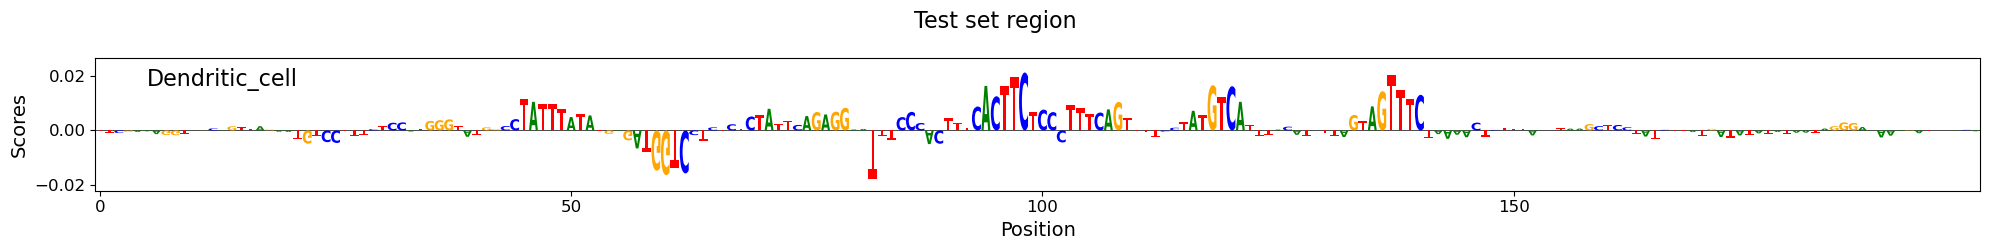

In [27]:
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=200,
    title="Test set region",
    height=2.5,
    #save_path='paperfigs/enhanceosome_5.pdf'
)

### Fig. 3c (bottom)

2025-03-13T16:53:19.542314+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


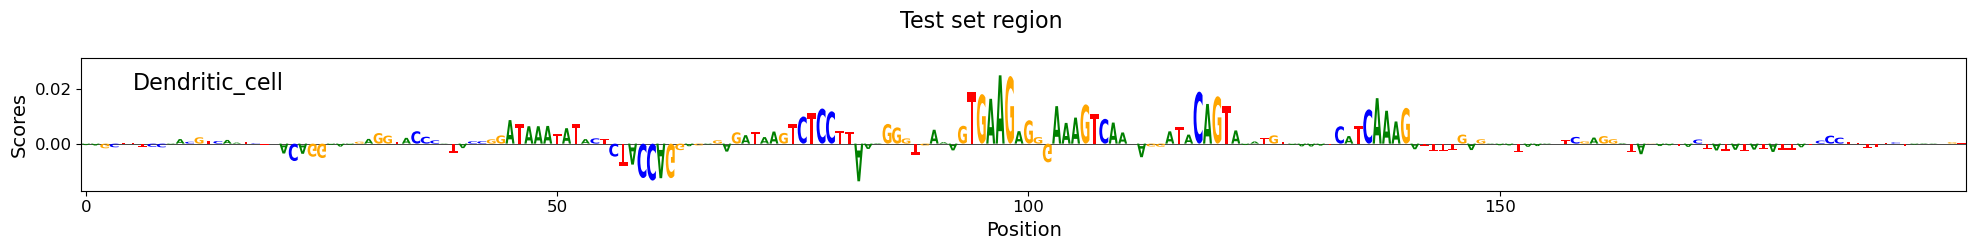

In [28]:
# random sequence of length 2114bp as an example
#sequence = "A" * 2114
classes_of_interest = ["Dendritic_cell"]

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    seq_rev,
    target_idx=class_idx,
    model=model,
)
scores[0,0]=scores[0,0][::-1,:]
one_hot_encoded_sequences[0]=one_hot_encoded_sequences[0][::-1,:]

%matplotlib inline
crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=200,
    title="Test set region",
    height=2.5,
    #save_path='paperfigs/enhanceosome_3.pdf'
)

# Modisco pattern analysis

In [29]:
# First we obtain the resulting modisco files per class
contribution_dir=f"{DATA_DIR}modisco/"

matched_files = crested.tl.modisco.match_h5_files_to_classes(
    contribution_dir=contribution_dir, classes=list(adata.obs_names)
)

In [30]:
matched_files

{'Bcell': '../../../crested_data/Figure_3/pbmc/modisco/Bcell_modisco_results.h5',
 'CD14_monocyte': '../../../crested_data/Figure_3/pbmc/modisco/CD14_monocyte_modisco_results.h5',
 'CD16_monocyte': '../../../crested_data/Figure_3/pbmc/modisco/CD16_monocyte_modisco_results.h5',
 'CD4_Tcell': '../../../crested_data/Figure_3/pbmc/modisco/CD4_Tcell_modisco_results.h5',
 'Cytotoxic_T_cell': '../../../crested_data/Figure_3/pbmc/modisco/Cytotoxic_T_cell_modisco_results.h5',
 'Dendritic_cell': '../../../crested_data/Figure_3/pbmc/modisco/Dendritic_cell_modisco_results.h5',
 'Natural_killer_cell': '../../../crested_data/Figure_3/pbmc/modisco/Natural_killer_cell_modisco_results.h5'}

In [31]:
# Then we cluster matching patterns, and define a pattern matrix [#classes, #patterns] describing their importance
all_patterns = crested.tl.modisco.process_patterns(
    matched_files,
    sim_threshold=4,  # The similarity threshold used for matching patterns. We take the -log10(pval), pval obtained through TOMTOM matching from tangermeme
    trim_ic_threshold=0.025,  # Information content (IC) threshold on which to trim patterns
    discard_ic_threshold=0.2,  # IC threshold used for discarding single instance patterns
    verbose=True,  # Useful for doing sanity checks on matching patterns
)
pattern_matrix = crested.tl.modisco.create_pattern_matrix(
    classes=list(adata.obs_names),
    all_patterns=all_patterns,
    normalize=False,
    pattern_parameter="seqlet_count_log",
)
pattern_matrix.shape

Reading file ../../../crested_data/Figure_3/pbmc/modisco/Bcell_modisco_results.h5
Match between Bcell_pos_patterns_12 and Bcell_pos_patterns_9 with similarity score 6.73
Match between Bcell_pos_patterns_13 and Bcell_pos_patterns_9 with similarity score 6.12
Match between Bcell_pos_patterns_18 and Bcell_pos_patterns_15 with similarity score 4.02
Match between Bcell_pos_patterns_21 and Bcell_pos_patterns_0 with similarity score 4.92
Match between Bcell_pos_patterns_24 and Bcell_pos_patterns_7 with similarity score 4.25
Reading file ../../../crested_data/Figure_3/pbmc/modisco/CD14_monocyte_modisco_results.h5
Match between CD14_monocyte_pos_patterns_1 and Bcell_pos_patterns_25 with similarity score 4.93
Match between CD14_monocyte_pos_patterns_2 and Bcell_pos_patterns_1 with similarity score 9.49
Match between CD14_monocyte_pos_patterns_5 and Bcell_pos_patterns_16 with similarity score 6.19
Match between CD14_monocyte_pos_patterns_8 and CD14_monocyte_pos_patterns_1 with similarity score 4.

(7, 62)

### Fig. 3d

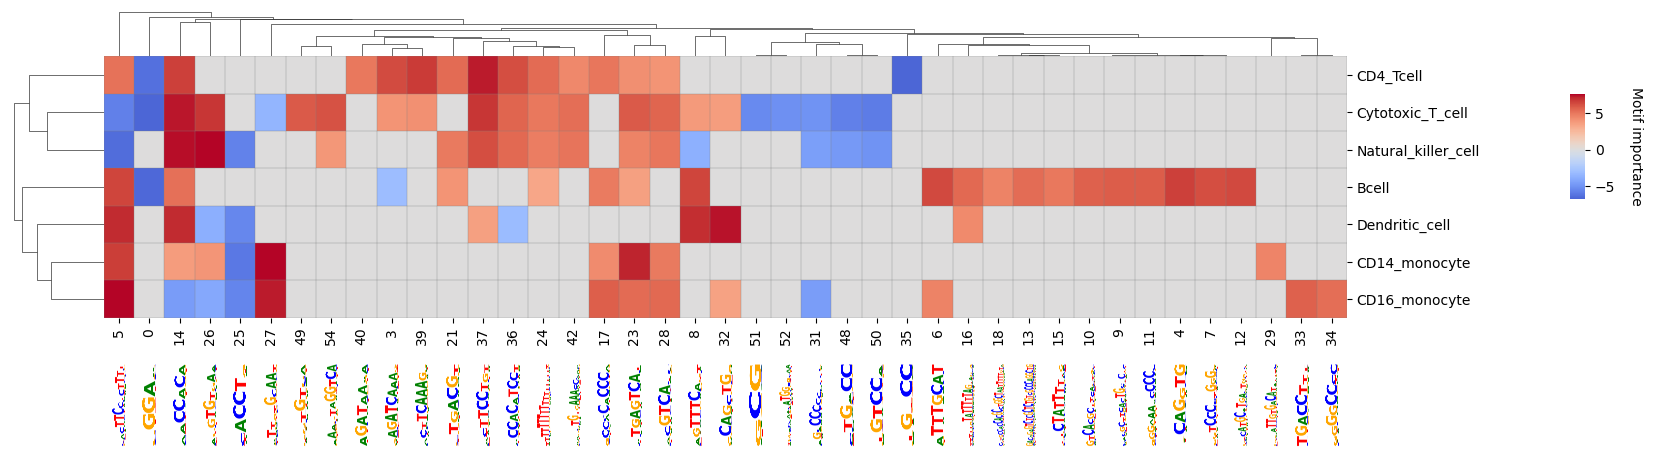

In [32]:
crested.pl.patterns.clustermap_with_pwm_logos(
    pattern_matrix=pattern_matrix,
    classes=list(adata.obs_names),
    pattern_dict=all_patterns,
    figsize=(15,2.5),
    grid= True,
    dendrogram_ratio = (0.07, 0.15),
    importance_threshold = 4.5,
    logo_height_fraction = 0.4,  # Fraction of clustermap height for x-tick images
    logo_y_padding=0.35,
    #save_path='paperfigs/pbmc_patterns_clustered.pdf',
)

# EBF1 degredation analysis

For this analysis you will need the mouse mm10 genome, potentially downloaded here: https://hgdownload.soe.ucsc.edu/downloads.html 

In [33]:
from pysam import FastaFile

chrom = "chr10"
start =80409514
end = 80433647

genome = '../../../mouse/biccn/mm10.fa'

upstream=20000
downstream=5000

cell_type='Bcell'
class_idx = list(adata.obs_names).index(cell_type)

strand='-'

scores, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    model=model,
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
    genome=genome
)

471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step


In [34]:
bigwig = f"{DATA_DIR}/mouse_bw/pre_Pax5_ctr_1.bw"
values = crested.utils.read_bigwig_region(bigwig, (chrom,start-upstream,end+downstream)) if strand =='+' else crested.utils.read_bigwig_region(bigwig, (chrom,start-downstream,end+upstream))
bw_values=values[0]
midpoints=values[1]

## Mutate a set of EBF1 TFBS

In [35]:
from Bio.Seq import Seq

genome_fasta = FastaFile(genome)


# Define start and end positions for the region
start_ = start - downstream
end_ = end + upstream

# Fetch the genomic sequence
sequence = genome_fasta.fetch(chrom, start_, end_)

# Define multiple target and replacement sequences
targets_and_replacements = [
    ("CCCCTGGG", "NNNNNNNN"),
    ("CCCTAGGG", "NNNNNNNN"),
    ("TCCCTGGG", "NNNNNNNN")
    # Add more (target, replacement) pairs here
]

# Initialize modified sequence and a list for tracking replacements
modified_sequence = sequence.upper()
replacements = []  # List to store replacement positions

# Function to find and replace sequences
def find_and_replace(sequence, target, replacement, start_offset, replacements):
    reverse_complement = str(Seq(target).reverse_complement())
    for i in range(len(sequence) - len(target) + 1):
        if sequence[i:i + len(target)] == target:
            start_pos = start_offset + i
            end_pos = start_pos + len(target)
            replacements.append((start_pos, end_pos))
            # Replace in the sequence
            sequence = (
                sequence[:i] + replacement + sequence[i + len(target):]
            )
    for i in range(len(sequence) - len(reverse_complement) + 1):
        if sequence[i:i + len(reverse_complement)] == reverse_complement:
            start_pos = start_offset + i
            end_pos = start_pos + len(reverse_complement)
            replacements.append((start_pos, end_pos))
            # Replace in the sequence
            sequence = (
                sequence[:i] + replacement + sequence[i + len(reverse_complement):]
            )
    return sequence

# Perform replacements for each target-replacement pair
for target_seq, replacement_seq in targets_and_replacements:
    modified_sequence = find_and_replace(
        modified_sequence, target_seq, replacement_seq, start_, replacements
    )

# Sort replacements by start position
replacements = sorted(replacements, key=lambda x: x[0])

# Output results
print(f"Number of replacements made: {len(replacements)}")
print(f"Replacements: {replacements}")

Number of replacements made: 18
Replacements: [(80405453, 80405461), (80417518, 80417526), (80418616, 80418624), (80420927, 80420935), (80423782, 80423790), (80429819, 80429827), (80430016, 80430024), (80431510, 80431518), (80431736, 80431744), (80432651, 80432659), (80438215, 80438223), (80441677, 80441685), (80442429, 80442437), (80442700, 80442708), (80443242, 80443250), (80443608, 80443616), (80444945, 80444953), (80448825, 80448833)]


In [36]:
from pysam import FastaFile
from Bio import SeqIO
from Bio.Seq import Seq
from io import StringIO
import tempfile

# Modify the sequence in the interval
with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.fa') as tmp_fasta:
    temp_fasta_path = tmp_fasta.name  # Save the temporary file path

    # Parse the original FASTA and write modified sequences to the temp file
    for record in SeqIO.parse(genome, "fasta"):
        if record.id == chrom:
            # Get the full sequence
            seq = str(record.seq)
            # Modify the specified interval
            updated_seq = seq[:start_] + modified_sequence + seq[end_:]
            record.seq = Seq(updated_seq)
        SeqIO.write(record, tmp_fasta, "fasta")  # Write all records to temp file

In [37]:
scores_mut, coordinates, min_loc, max_loc, tss_position = crested.tl.score_gene_locus(
    model=model,
    chr_name=chrom,
    gene_start=start,
    gene_end=end,
    target_idx=class_idx,
    strand=strand,
    upstream=upstream,
    downstream=downstream,
    step_size=100,
    genome=temp_fasta_path
)


471/471 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step


In [38]:
# Cleanup: Delete the temporary file when done
import os
os.remove(temp_fasta_path)

In [39]:
bigwig_mut = f"{DATA_DIR}/mouse_bw/pre_Ebf1_6h_1.bw"
values = crested.utils.read_bigwig_region(bigwig_mut, (chrom,start-upstream,end+downstream)) if strand =='+' else crested.utils.read_bigwig_region(bigwig_mut, (chrom,start-downstream,end+upstream))
bw_values_mut=values[0]
midpoints_mut=values[1]

In [40]:
import numpy as np
from scipy.stats import pearsonr

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(bw_values, scores[:len(bw_values)])

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

# Calculate Pearson correlation coefficient and p-value
correlation_coefficient, p_value = pearsonr(bw_values_mut, scores_mut[:len(bw_values_mut)])

# Print the results
print(f"Pearson correlation coefficient: {correlation_coefficient}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.554911345046326
P-value: 0.0
Pearson correlation coefficient: 0.594840421114821
P-value: 0.0


### Fig. 3h

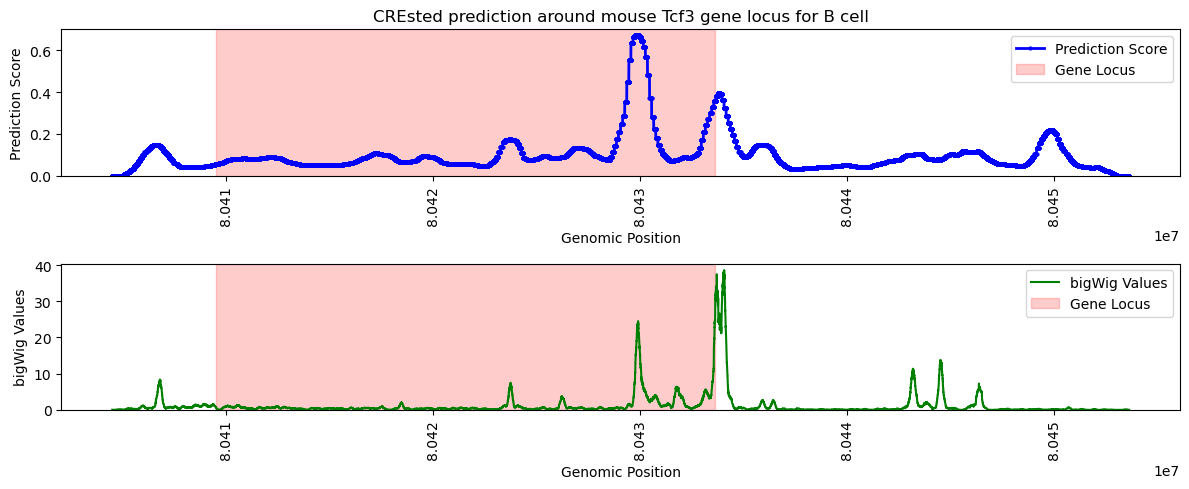

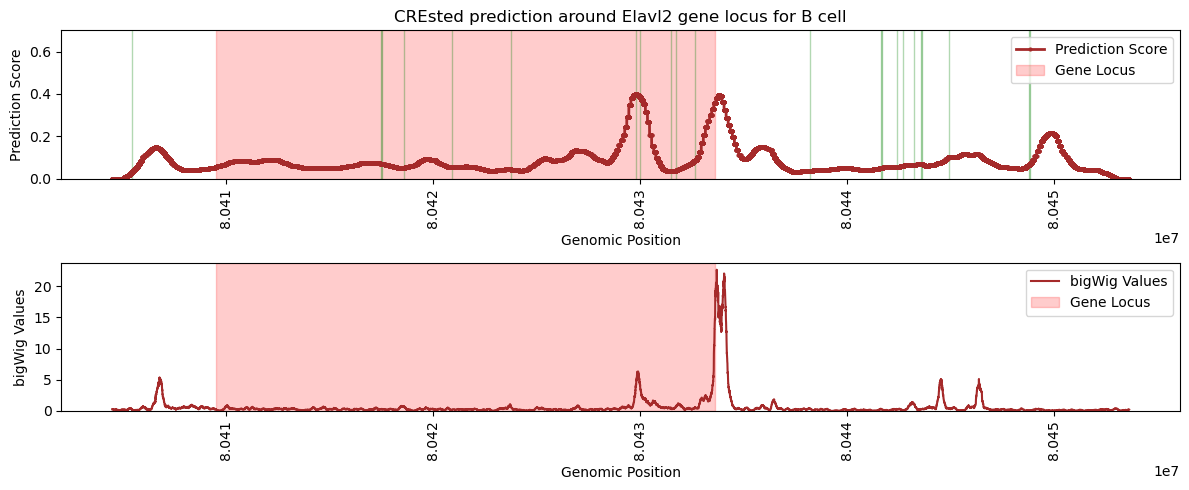

In [41]:
crested.pl.hist.locus_scoring(
    scores,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    title="CREsted prediction around mouse Tcf3 gene locus for B cell",
    bigwig_values=bw_values,
    bigwig_midpoints=midpoints,
    grid=False,
    ylim=(0, 0.7),
    figsize=(12,5),
    marker_size=2,
    line_width=2,
    #filename='paperfigs/tcf3_locus.pdf'
)

crested.pl.hist.locus_scoring(
    scores_mut,
    (min_loc, max_loc),
    gene_start=start,
    gene_end=end,
    ylim=(0, 0.7),
    title="CREsted prediction around Elavl2 gene locus for B cell",
    grid=False,
    figsize=(12,5),
    highlight_positions=replacements,
    bigwig_values=bw_values_mut,
    bigwig_midpoints=midpoints_mut,
    marker_size=2,
    line_width=2,
    line_colors=('brown', 'brown'),
    #filename='paperfigs/tcf3_locus_degraded.pdf'
)

## Contribution scores for key regions

In [42]:
from pysam import FastaFile

chrom = 'chr10'
start = 80428868
end = 80430982

sequence1 = genome_fasta.fetch(chrom, start, end).upper()

start=80422684
end=start+2114

sequence2 = genome_fasta.fetch(chrom, start, end).upper()

### Fig. 3i (top)

2025-03-13T16:57:54.734648+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


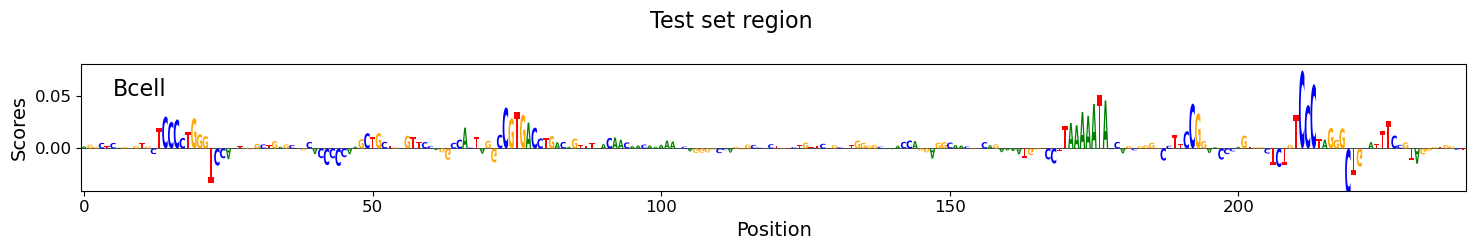

In [43]:
classes_of_interest = ["Bcell"]

class_idx = list(adata.obs_names.get_indexer(classes_of_interest))

scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence1,
    target_idx=class_idx,
    model=model,
)

crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=240,
    title="Test set region",
    height=2.5,
    width=15,
    ylim=(-0.04, 0.08),
    #save_path='paperfigs/ebf1_degron_reg2.pdf'
) 

### Fig. 3i (bottom)

2025-03-13T16:57:57.018910+0100 INFO Calculating contribution scores for 1 class(es) and 1 region(s).


Model: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


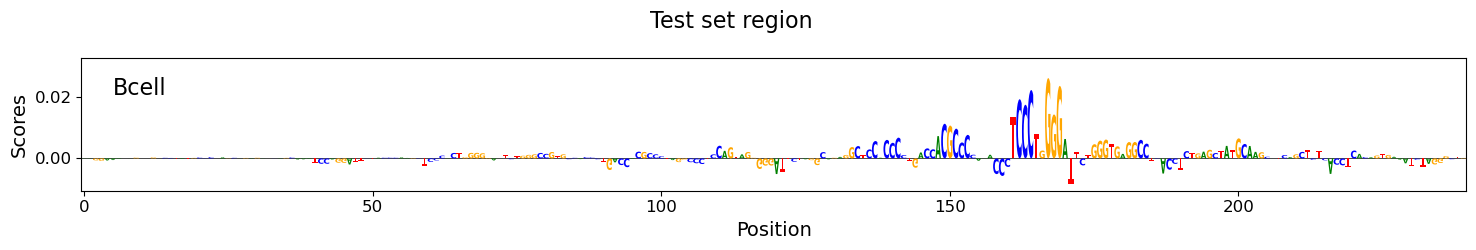

In [44]:
scores, one_hot_encoded_sequences = crested.tl.contribution_scores(
    sequence2,
    target_idx=class_idx,
    model=model,
)

crested.pl.patterns.contribution_scores(
    scores,
    one_hot_encoded_sequences,
    sequence_labels=[''],
    class_labels=classes_of_interest,
    zoom_n_bases=240,
    title="Test set region",
    height=2.5,
    width=15,
    #save_path='paperfigs/ebf1_degron_reg2.pdf'
)